In [4]:
#import packages
import pandas as pd
import numpy as np
import glob,os
import matplotlib.dates as mdates

#to plot within notebook
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn

#to set seed
np.random.seed(0) # for reproducibility
import statsmodels.tsa.stattools as ts 
import statsmodels.api as sm
from statsmodels.tsa.vector_ar.vecm import coint_johansen
#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10
#for cointegration test 
from statsmodels.tsa.stattools import coint
import scipy

from datetime import datetime, timedelta
import statsmodels.regression.linear_model as rg
import arch.unitroot as at
import warnings
warnings.filterwarnings("ignore")

In [5]:
data = pd.read_excel(r'./data/data_1906-2105.xlsx',index_col=0)
print(data.shape)

(17508, 21)


In [6]:
data.index = pd.to_datetime(data.index, unit='ms')
data = data[~data.index.duplicated(keep='first')]
print(data.shape)
data = data.resample('60T').pad()
data.head()

(17508, 21)


,ADAUSDT,BATUSDT,BTCUSDT,BTTUSDT,DASHUSDT,EOSUSDT,ETCUSDT,ETHUSDT,HOTUSDT,IOTAUSDT,...,LTCUSDT,NEOUSDT,OMGUSDT,QTUMUSDT,THETAUSDT,TRXUSDT,VETUSDT,XLMUSDT,XMRUSDT,XRPUSDT
Time,,,,,,,,,,,,,,,,,,,,,
2019-06-01 00:00:00,0.09022,0.3506,8585.99,0.001578,166.91,8.5587,8.7086,274.72,0.002300,0.5132,...,116.12,13.755,2.2957,3.491,0.13546,0.03335,0.007719,0.13455,93.83,0.44145
2019-06-01 01:00:00,0.08945,0.3480,8567.58,0.001594,165.82,8.5188,8.6676,272.24,0.002306,0.5111,...,115.14,13.674,2.2876,3.516,0.13394,0.03331,0.007767,0.13355,93.48,0.43855
2019-06-01 02:00:00,0.09004,0.3487,8555.00,0.001633,165.67,8.4997,8.7712,271.06,0.002287,0.5109,...,114.96,14.277,2.3371,3.700,0.13506,0.03407,0.007701,0.13389,93.36,0.43840
2019-06-01 03:00:00,0.08960,0.3491,8552.75,0.001605,166.11,8.4419,8.8010,269.70,0.002278,0.5085,...,114.49,13.985,2.3156,3.682,0.13360,0.03370,0.007707,0.13292,93.11,0.43638
2019-06-01 04:00:00,0.08950,0.3493,8561.23,0.001643,165.16,8.5013,8.7862,270.58,0.002323,0.5056,...,114.83,13.983,2.3150,3.676,0.13402,0.03378,0.007600,0.13329,93.07,0.43905


In [7]:
data.tail()

,ADAUSDT,BATUSDT,BTCUSDT,BTTUSDT,DASHUSDT,EOSUSDT,ETCUSDT,ETHUSDT,HOTUSDT,IOTAUSDT,...,LTCUSDT,NEOUSDT,OMGUSDT,QTUMUSDT,THETAUSDT,TRXUSDT,VETUSDT,XLMUSDT,XMRUSDT,XRPUSDT
Time,,,,,,,,,,,,,,,,,,,,,
2021-05-31 19:00:00,1.6619,0.7414,36863.67,0.003729,188.41,6.2327,67.868,2627.20,0.008825,1.0850,...,183.63,53.775,6.3546,11.806,6.706,0.07499,0.11997,0.39177,259.31,0.9941
2021-05-31 20:00:00,1.6692,0.7395,36675.06,0.003722,189.40,6.3347,68.013,2598.87,0.008759,1.0781,...,182.22,53.831,6.3446,11.756,6.763,0.07508,0.11934,0.39045,261.36,0.9923
2021-05-31 21:00:00,1.6825,0.7496,36932.55,0.003756,191.60,6.3368,68.356,2627.64,0.008861,1.0883,...,183.82,54.126,6.4246,11.781,6.884,0.07543,0.12118,0.39131,268.32,1.0016
2021-05-31 22:00:00,1.7005,0.7529,36879.23,0.003759,195.65,6.3427,68.479,2644.55,0.008903,1.0914,...,183.83,54.515,6.4613,11.884,6.983,0.07545,0.12263,0.39424,272.28,1.0100
2021-05-31 23:00:00,1.7373,0.7679,37253.81,0.003842,197.42,6.6297,70.019,2706.15,0.009011,1.1147,...,187.97,55.865,6.5988,12.402,7.106,0.07679,0.12588,0.40243,272.21,1.0409


In [8]:
def plot_return(dt, title):
    fig = plt.figure(figsize = (16,8))
    plt.rcParams.update({'font.size':10})
    plt.xticks(rotation=45)
    plt.plot(dt)
    plt.xlabel("Date")
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.grid(True)
    plt.legend(dt.columns.to_list(), loc='best')
    plt.show()

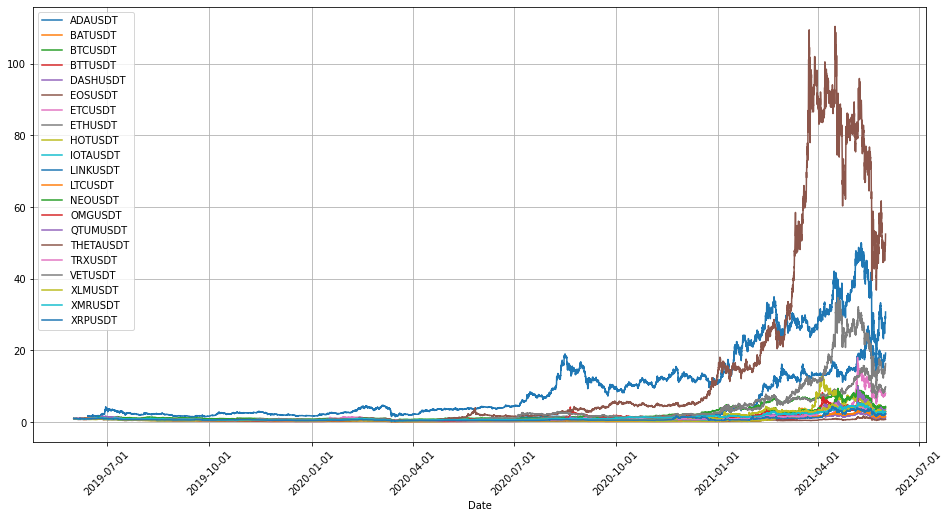

In [9]:
# Normalize prices by first value
assets = data.columns.to_list()
norm_prices = data.divide(data.iloc[0])
plot_return(norm_prices, 'Performance of cryptocurrencies')

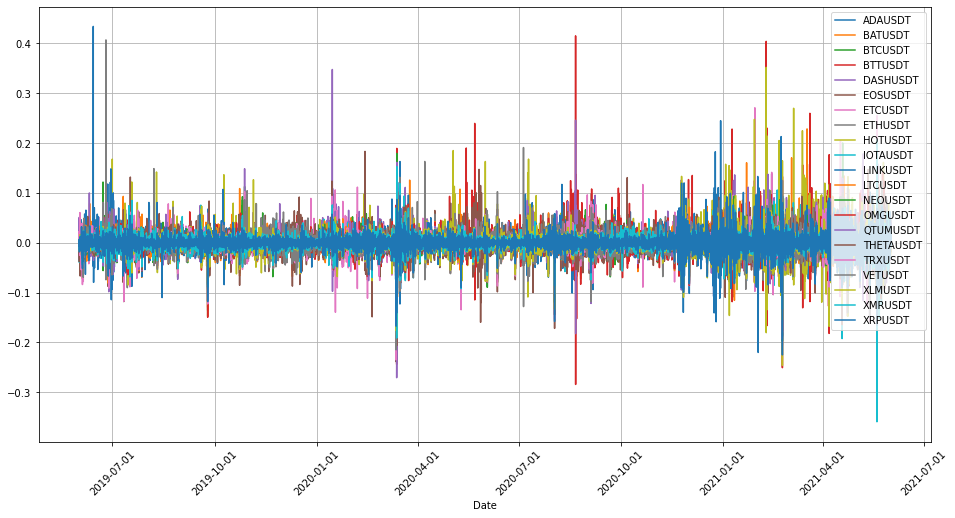

,ADAUSDT,BATUSDT,BTCUSDT,BTTUSDT,DASHUSDT,EOSUSDT,ETCUSDT,ETHUSDT,HOTUSDT,IOTAUSDT,...,LTCUSDT,NEOUSDT,OMGUSDT,QTUMUSDT,THETAUSDT,TRXUSDT,VETUSDT,XLMUSDT,XMRUSDT,XRPUSDT
Time,,,,,,,,,,,,,,,,,,,,,
2019-06-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-06-01 01:00:00,-0.008571,-0.007443,-0.002146,0.010277,-0.006552,-0.004673,-0.004719,-0.009068,0.002605,-0.004100,...,-0.008475,-0.005906,-0.003535,0.007136,-0.011284,-0.001200,0.006199,-0.007460,-0.003737,-0.006591
2019-06-01 02:00:00,0.006574,0.002009,-0.001469,0.024168,-0.000905,-0.002245,0.011882,-0.004344,-0.008317,-0.000391,...,-0.001565,0.043154,0.021408,0.051009,0.008327,0.022560,-0.008534,0.002543,-0.001285,-0.000342
2019-06-01 03:00:00,-0.004899,0.001146,-0.000263,-0.017230,0.002652,-0.006823,0.003392,-0.005030,-0.004031,-0.004709,...,-0.004097,-0.020665,-0.009242,-0.004877,-0.010869,-0.010919,0.000779,-0.007271,-0.002681,-0.004618
2019-06-01 04:00:00,-0.001117,0.000573,0.000991,0.023273,-0.005736,0.007012,-0.001683,0.003258,0.019693,-0.005719,...,0.002965,-0.000143,-0.000259,-0.001631,0.003139,0.002371,-0.013981,0.002780,-0.000430,0.006100


In [10]:
def cal_return(data):
    '''calculate log return'''
    dr = data.apply(lambda x: np.log(x/x.shift(1)).fillna(0))
    return dr

dr = cal_return(data)
plot_return(dr, "Percentage changes")
dr.head()

# Refinement 1 - cointegration test & multiple validation periods

In [11]:
train_periods = [(datetime(2019,6,1),datetime(2020,12,1)-timedelta(hours=1))] #18 month
test_periods = [(datetime(2020,12,1),datetime(2021,6,1)-timedelta(hours=1))] #6 month

In [12]:
print(train_periods)
print("------------------------------")
print(test_periods)

[(datetime.datetime(2019, 6, 1, 0, 0), datetime.datetime(2020, 11, 30, 23, 0))]
------------------------------
[(datetime.datetime(2020, 12, 1, 0, 0), datetime.datetime(2021, 5, 31, 23, 0))]


In [13]:
def coint_effect(data):
    
    """long-term cointegration test"""
    
    assets = data.columns.to_list()
#     normdata = np.log(data)
    coint_mat = []
    for a1 in assets:
        coint_one = []
        for a2 in assets:
            test_result = ts.coint(data[a1], data[a2])
            coint_one.append(test_result[1])
        coint_mat.append(coint_one)
    coint_mat = pd.DataFrame(coint_mat, columns = assets, index=assets)
    
    return coint_mat

(datetime.datetime(2019, 6, 1, 0, 0), datetime.datetime(2020, 11, 30, 23, 0))


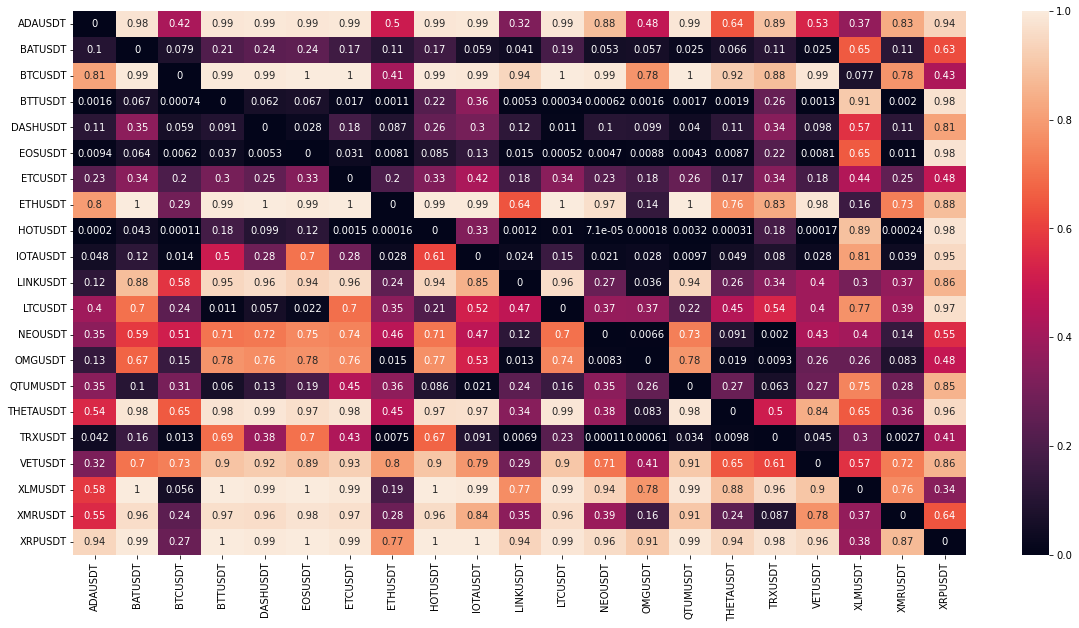

In [90]:
# Pick pairs (insample period)
n_pairs = 10
alpha = 0.05

dt_dict = {} # store all insample data and variables
for ix in range(len(train_periods)):
    print(train_periods[ix])
    dt_dict[ix] = {}
    dtr = train_periods[ix]
    dtrain = data.loc[dtr[0]:dtr[1]]
    drtrain = dr.loc[dtr[0]:dtr[1]]
    dts = test_periods[ix]
    dtest = data.loc[dts[0]:dts[1]]
    drtest = dr.loc[dts[0]:dts[1]]
    
    #first check ADF test
    
    #second calculate cointegration effect
    coints = coint_effect(dtrain)
    sn.heatmap(coints, annot=True)
    plt.show()
    assets = coints.columns.to_list()
    pairs = []
    for i in range(coints.shape[1]):
        for j in range(i+1, coints.shape[0]):
            if coints.iloc[i,j] < alpha:
                pairs.append((assets[i],assets[j]))
    
    # third rank pairwise correlation
    if len(pairs) <= 10:
        pairs2 = pairs
    else:
        corrs = pd.Series(index=range(len(pairs)))
        for i, pair in enumerate(pairs):
            corr = np.corrcoef(drtrain[pair[0]],drtrain[pair[1]])[1][0]
            corrs.iloc[i] = corr
        corrs = corrs.sort_values(ascending=False)
        pairs2 = [pairs[i] for i in list(corrs.index[:n_pairs])]
    
    l, s = zip(*pairs2)
    dtr_l = dtrain[list(l)]
    dtr_s = dtrain[list(s)]
    dts_l = dtest[list(l)]
    dts_s = dtest[list(s)]
    drtr_l = drtrain[list(l)]
    drtr_s = drtrain[list(s)]
    drts_l = drtest[list(l)]
    drts_s = drtest[list(s)]
    
    dt_dict[ix]['dtr_l'] = dtr_l
    dt_dict[ix]['dtr_s'] = dtr_s
    dt_dict[ix]['dts_l'] = dts_l
    dt_dict[ix]['dts_s'] = dts_s
    dt_dict[ix]['drtr_l'] = drtr_l
    dt_dict[ix]['drtr_s'] = drtr_s
    dt_dict[ix]['drts_l'] = drts_l
    dt_dict[ix]['drts_s'] = drts_s

In [14]:
import pickle
# pickle.dump(dt_dict, open("./data/dt_dict_%s_1.p" % alpha,'wb'))
dt_dict = pickle.load(open("./data/dt_dict_0.05_1.p",'rb'))

(datetime.datetime(2019, 6, 1, 0, 0), datetime.datetime(2020, 11, 30, 23, 0))


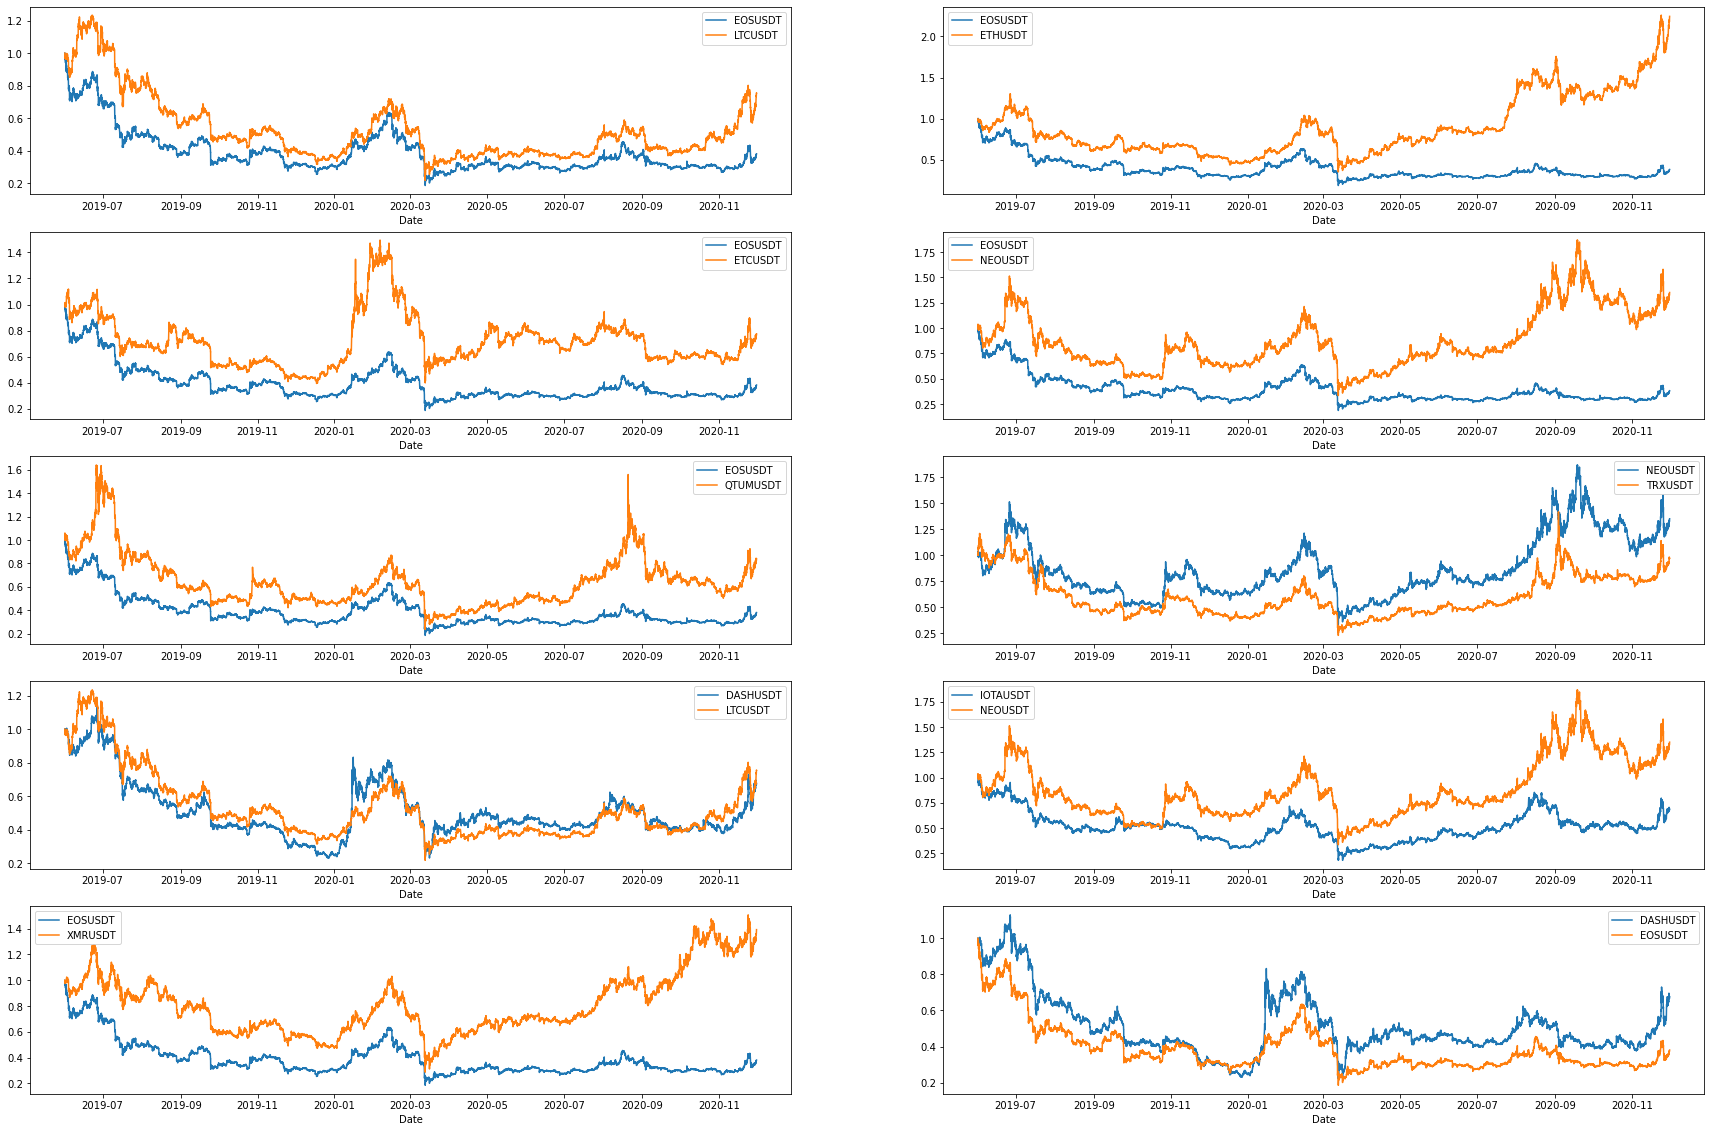

In [15]:
for ix in range(len(train_periods)):
    print(train_periods[ix])
    dtr_l = dt_dict[ix]['dtr_l']
    dtr_s = dt_dict[ix]['dtr_s']
    drtr_l = dt_dict[ix]['drtr_l']
    drtr_s = dt_dict[ix]['drtr_s'] 
    
    pairs = [(dtr_l.columns[x],dtr_s.columns[x]) for x in range(len(dtr_l.columns))]
    plt.figure(figsize = (30,20))
    for i in range(len(pairs)):
        plt.subplot(5,2,i+1)
        plt.plot(dtr_l.iloc[:,i].divide(dtr_l.iloc[0,i]), label = pairs[i][0])
        plt.plot(dtr_s.iloc[:,i].divide(dtr_s.iloc[0,i]), label = pairs[i][1])
        plt.xlabel("Date")
        plt.legend()
    plt.show()

In [16]:
def corr_test(dr, assets, n_pair):
    corr_mat = dr.corr().stack()
    corr_mat = corr_mat[corr_mat!=1].sort_values(ascending=False)
    pairs = corr_mat.iloc[[2*i for i in range(n_pair)]].index.to_list()
    
    return pairs

def beta_hedge(dr_btc, dr_pf, np, ntp):
#     dr_btc = sm.add_constant(dr_btc)
    beta = sm.OLS(dr_pf, dr_btc).fit().params[0]
    if beta >= 0:
        # short bitcoin to hedge
        nhp = - ntp*beta
        if abs(nhp) > np - ntp:
            nhp = - (np - ntp)
        cp = np - ntp #cash position
    else:
        # long bitcoin to hedge
        nhp = - ntp*beta
        if abs(nhp) > np - ntp:
            nhp = np - ntp
        cp = np - ntp - nhp #cash position
        
    return (beta, nhp, cp)

In [17]:
# proposed strategy (base)
def signal1(trspread, tsspread, window=168, uenter=2, lenter=-2, uexit=0.5, lexit=-0.5):
    
    """
    sig = (z - z_rollmean)/z_rollstd
    ---------------------------------
    uenter, lenter: enter threshold
    uexit, lexit: exit threshold
    """
    spread = pd.concat([trspread.iloc[-window+1:,:], tsspread],axis=0)
    spread_mean = spread.rolling(window=window).mean()
    spread_std = spread.rolling(window=window).std()
    z_score = (spread - spread_mean) / spread_std
    z_score = z_score.dropna()
    signals = z_score.copy()
    print(signals.shape)
    
    for j in range(signals.shape[1]):
        OPEN = False
        for i in range(1,signals.shape[0]):
            if pd.isna(z_score.iloc[i,j]): continue
            elif (z_score.iloc[i,j] <lenter) and (z_score.iloc[i-1,j] > lenter) and not OPEN: 
                signals.iloc[i,j] = 2 # undervalue - open long - buy l sell s
                OPEN = True
            elif (z_score.iloc[i,j] > uenter) and (z_score.iloc[i-1,j] < uenter) and not OPEN: 
                signals.iloc[i,j] = -2 # overvalue - open short - sell l buy s
                OPEN = True
            elif (z_score.iloc[i,j] < uexit) and (z_score.iloc[i-1,j] > uexit) and OPEN: 
                OPEN = False # close short - sell l buy s
                signals.iloc[i,j] = 3
            elif (z_score.iloc[i,j] > lexit) and (z_score.iloc[i-1,j] < lexit) and OPEN: 
                OPEN = False # close long - sell l buy s
                signals.iloc[i,j] = -3
            else:
                if OPEN:
                    signals.iloc[i,j] = 1 if signals.iloc[i-1,j] > 0 else -1
                else:
                    signals.iloc[i,j] = 0
                    OPEN = False
    signals = signals.fillna(0)

    return signals, z_score
        
def signal2(drtr_l, drtr_s, drts_l, drts_s, pairs, window=168, uenter=1, lenter=-1, uexit=0.5, lexit=-0.5):
    dr_l = pd.concat([drtr_l.iloc[-window+1:],drts_l],axis=0)
    dr_s = pd.concat([drtr_s.iloc[-window+1:],drts_s],axis=0)
    dr_ratio = pd.DataFrame(dr_l.values / dr_s.values, index=dr_l.index, columns=pairs).fillna(0)
    dr_ratio_mean = dr_ratio.rolling(window).mean()
    dr_ratio_std = dr_ratio.rolling(window).std()
    z_score = (dr_ratio - dr_ratio_mean)/dr_ratio_std
    z_score = z_score.dropna()
    signals = z_score.copy()
    
    for j in range(signals.shape[1]):
        OPEN = False
        for i in range(1,signals.shape[0]):
            if pd.isna(z_score.iloc[i,j]): continue
            elif (z_score.iloc[i,j] <lenter) and (z_score.iloc[i-1,j] > lenter) and not OPEN: 
                signals.iloc[i,j] = 2 # undervalue - open long - buy l sell s
                OPEN = True
            elif (z_score.iloc[i,j] > uenter) and (z_score.iloc[i-1,j] < uenter) and not OPEN: 
                signals.iloc[i,j] = -2 # overvalue - open short - sell l buy s
                OPEN = True
            elif (z_score.iloc[i,j] < uexit) and (z_score.iloc[i-1,j] > uexit) and OPEN: 
                OPEN = False # close short - sell l buy s
                signals.iloc[i,j] = 3
            elif (z_score.iloc[i,j] > lexit) and (z_score.iloc[i-1,j] < lexit) and OPEN: 
                OPEN = False # close long - sell l buy s
                signals.iloc[i,j] = -3
            else:
                if OPEN:
                    signals.iloc[i,j] = 1 if signals.iloc[i-1,j] > 0 else -1
                else:
                    signals.iloc[i,j] = 0
                    OPEN = False
    signals = signals.fillna(0)

    return signals, z_score
    
def fill_cost(signals, cost, beta):
    
    """Transaction cost based on signal"""
    
    def costmap(x,beta):
        if abs(x) == 2:
            return (1+beta)*np.log(1/(1+cost))
        elif abs(x) == 3:
            return (1+beta)*np.log(1-cost)
        else:
            return 0
    fill_cost = signals.copy()
    for pair in range(signals.shape[1]):
        b = beta[pair]
        fill_cost.iloc[:,pair] = signals.iloc[:,pair].map(lambda x: costmap(x,b))
        
    return fill_cost

def finance_cost(signals, unit, beta):
    
    def costmap2(x, beta):
        if (x == 1) or (x == -3): #long position - finance cost = beta*unit
            return np.log(1-unit * beta)
        elif (x == -1) or (x == 3): #short position - finance cost = unit
            return np.log(1-unit)
        else:
            return 0
    fin_cost = signals.copy()
    for pair in range(signals.shape[1]):
        b = beta[pair]
        fin_cost.iloc[:,pair] = signals.iloc[:,pair].map(lambda x: costmap2(x,b))
    return fin_cost

    
def pct_return(dr_l, dr_s, signals1, signals2, ret_cost, fin_cost, beta):
        
    pf_ret = pd.DataFrame(index=dr_l.index, columns = beta.index).fillna(0)
    for pair in range(len(beta.index)):
        for ix in range(len(pf_ret)):
            if (signals1.iloc[ix,pair] == 2) and (signals2.iloc[ix,pair] > 0):
                pf_ret.iloc[ix,pair] = ret_cost.iloc[ix,pair]
            elif (signals1.iloc[ix,pair] == -2) and (signals2.iloc[ix, pair] < 0):
                pf_ret.iloc[ix,pair] = ret_cost.iloc[ix,pair]
            elif signals1.iloc[ix,pair] == -3:
                pf_ret.iloc[ix,pair] = dr_l.iloc[ix,pair] - beta[pair]*dr_s.iloc[ix,pair] + ret_cost.iloc[ix,pair]
            elif signals1.iloc[ix,pair] == 3:
                pf_ret.iloc[ix,pair] = - (1/beta[pair]) * dr_l.iloc[ix,pair] + dr_s.iloc[ix,pair] + ret_cost.iloc[ix,pair]
            elif signals2.iloc[ix,pair] == -3:
                pf_ret.iloc[ix,pair] = dr_l.iloc[ix,pair] - beta[pair]*dr_s.iloc[ix,pair] + ret_cost.iloc[ix,pair]
            elif signals2.iloc[ix,pair] == 3:
                pf_ret.iloc[ix,pair] = - (1/beta[pair]) * dr_l.iloc[ix,pair] + dr_s.iloc[ix,pair] + ret_cost.iloc[ix,pair]
            elif (signals1.iloc[ix,pair] == 1) and (signals2.iloc[ix, pair] > 0):
                pf_ret.iloc[ix,pair] = dr_l.iloc[ix,pair] - beta[pair]*dr_s.iloc[ix,pair]
            elif (signals1.iloc[ix,pair] == -1)  and (signals2.iloc[ix, pair] < 0):
                pf_ret.iloc[ix,pair] = - (1/beta[pair])* dr_l.iloc[ix,pair] + dr_s.iloc[ix,pair]
            else: # sinalsg.iloc[ix,pair] == 0
                pf_ret.iloc[ix,pair] = 0
                
        # close position on last day of test period 
        if abs(signals1.iloc[-1,pair]) == 3:
            continue
        else:
            pf_ret.iloc[-1,pair] = 0
        
        # post-fincost
        pf_ret = pf_ret + fin_cost

    return pf_ret


(datetime.datetime(2020, 12, 1, 0, 0), datetime.datetime(2021, 5, 31, 23, 0))
(EOSUSDT, LTCUSDT)     0.287763
(EOSUSDT, ETHUSDT)     0.211901
(EOSUSDT, ETCUSDT)     0.644481
(EOSUSDT, NEOUSDT)     0.471346
(EOSUSDT, QTUMUSDT)    1.405283
(NEOUSDT, TRXUSDT)    -0.605875
(DASHUSDT, LTCUSDT)    1.080758
(IOTAUSDT, NEOUSDT)   -0.550363
(EOSUSDT, XMRUSDT)     0.269550
(DASHUSDT, EOSUSDT)    3.645346
dtype: float64
(4368, 10)


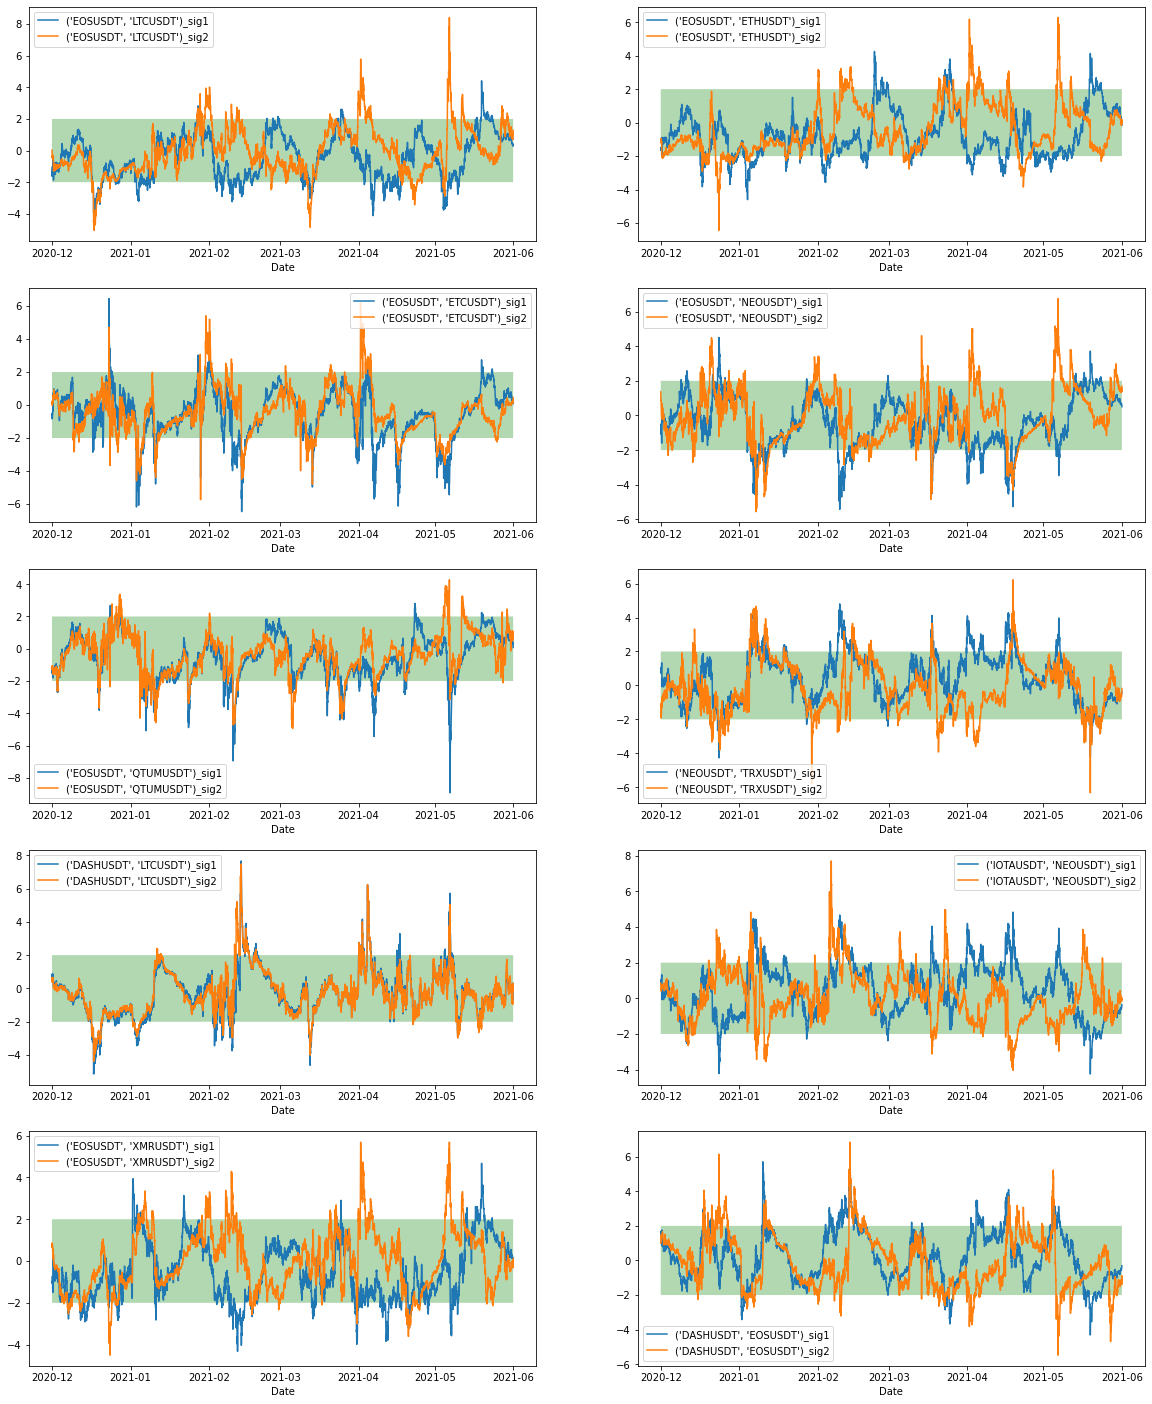

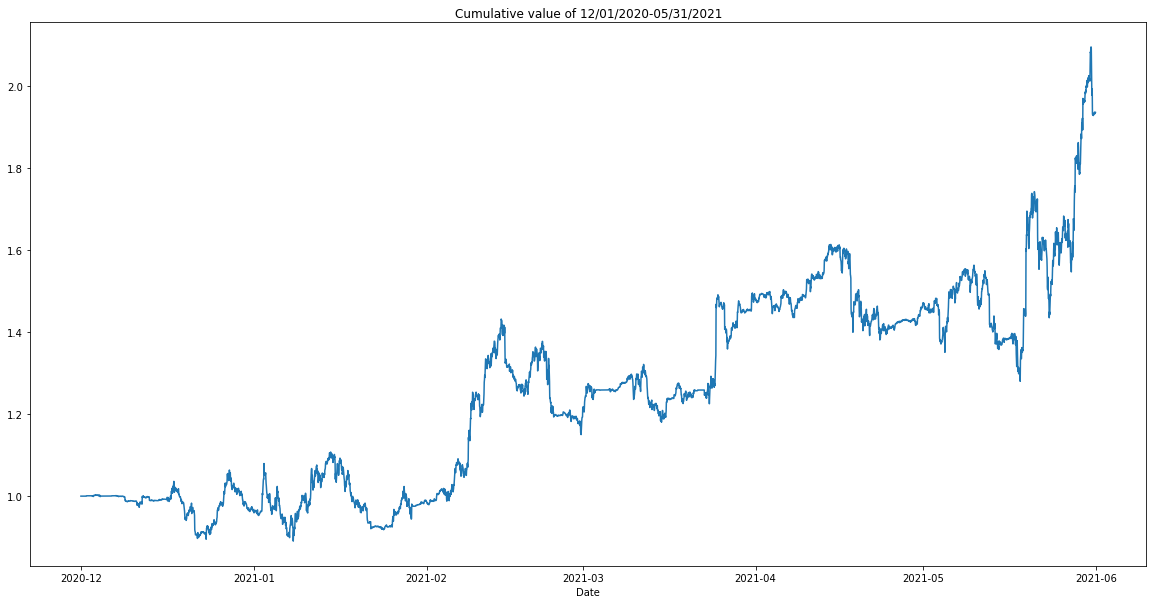

In [18]:
# Signal Portfolio setup
n_pairs = 10 
window = 360 # window for z-score roll mean
fillcs = 2e-3 #percentage fill cost (per $)
fincs = 15e-6 #percentage finance cost (per $/hour)

#$ portfolio setup
ttl_np = 1e6
fraction = 0.5

# records
signals_all = {}
z_scores_all = {}
fill_csall = {}
fin_csall = {}
cryp_retall = {}
cryp_pfall = {}
hedge_pfall = {}
pf_retall = []

for ix in range(len(test_periods)):
    print(test_periods[ix])
    dtr_l = dt_dict[ix]['dtr_l']
    dtr_s = dt_dict[ix]['dtr_s']
    drtr_l = dt_dict[ix]['drtr_l']
    drtr_s = dt_dict[ix]['drtr_s'] 
    
    dts_l = dt_dict[ix]['dts_l']
    dts_s = dt_dict[ix]['dts_s']
    drts_l = dt_dict[ix]['drts_l']
    drts_s = dt_dict[ix]['drts_s'] 
    
    l = dts_l.columns.to_list()
    s = dts_s.columns.to_list()
    pairs = [(l[p],s[p]) for p in range(len(l))]

    # pairwise beta
    betas = []
    for i in range(len(pairs)):
        pair_l = np.log(dtr_l.iloc[:,i])
        pair_s = np.log(dtr_s.iloc[:,i])
#         pair_s = sm.add_constant(dtr_s.iloc[:,i])
        beta = sm.OLS(pair_l, pair_s).fit().params[0]
        betas.append(beta)
    betas = pd.Series(betas, index = pairs)
    print(betas)

    # train period spread
    pair_spreads = []
    for b in range(len(pairs)):
        temp = dtr_l.iloc[:,b] - betas.iloc[b] * dtr_s.iloc[:,b]
        pair_spreads.append(temp)
    train_spread = pd.concat(pair_spreads,axis=1)
    train_spread.columns = pairs

    #  test period spread
    pair_spreads = []
    for b in range(len(pairs)):
        temp = dts_l.iloc[:,b] - betas.iloc[b] * dts_s.iloc[:,b]
        pair_spreads.append(temp)
    test_spread = pd.concat(pair_spreads,axis=1)
    test_spread.columns = pairs

    # calculate all signals
    # signal 1
    signals1, z_scores1 = signal1(train_spread, test_spread, window=window) 
    # signal 2
    signals2, z_scores2 = signal2(dtr_l, dtr_s, dts_l, dts_s, pairs, window=window)
    z_scores_all[ix] = z_scores1
    signals_all[ix] = signals1

    # fill cost
    fill_costs = fill_cost(signals1, fillcs, betas) 
    fill_csall[ix] = fill_costs
    
    # finance cost
    fin_costs = finance_cost(signals1, fincs, betas)
    fin_csall[ix] = fin_costs
    
    # backtest crypto portfolio percentage return
    cryp_pctret = pct_return(drts_l, drts_s, signals1, signals2, fill_costs, fin_costs, betas)
    cryp_retall[ix] = cryp_pctret
    
    ##########################################################################################################################
    plt.figure(figsize = (20,25))
    for i in range(len(pairs)):
        plt.subplot(5,2,i+1)
        plt.plot(z_scores1.iloc[:,i], label = str(pairs[i])+'_sig1')
        plt.plot(z_scores2.iloc[:,i], label = str(pairs[i])+'_sig2')
        plt.fill_between(z_scores1.index,-2,2,facecolor='green', alpha=0.3)
        plt.xlabel("Date")
        plt.legend()
    plt.show()
    
    ###########################################################################################################################

    # 1. crypto $ portfolio 
    cryp_np = ttl_np * fraction
    cryp_pf = pd.DataFrame(index=cryp_pctret.index, columns=cryp_pctret.columns).fillna(cryp_np/n_pairs) * cryp_pctret
    cryp_pfall[ix] = cryp_pf
    

    # 2. hedge $ portfolio
    dr_btc = dr['BTCUSDT']
    btc = data['BTCUSDT']
    
    hedge_sig = pd.DataFrame(index=cryp_pctret.index, columns =['BTCUSDT']).fillna(0)
    hedge_pf = pd.DataFrame(index=cryp_pctret.index, columns =['BTCUSDT']).fillna(0)
    # cash_pf = pd.DataFrame(index=cryp_pctret.index, columns =['cash']).fillna(0)
    trade_records = [None]
    for i in range(len(cryp_pctret)):
        date = cryp_pctret.index[i]
        trade_pairs = cryp_pctret.iloc[i,:][cryp_pctret.iloc[i,:]!= 0].index.to_list()

        btc_np_old = 0 # record previous to calculate net change of hedge position (dynamic hedge)
        if trade_pairs:
            last_pairs = trade_records[-1]
            if trade_pairs != last_pairs:
                trade_records.append(trade_pairs)
                direction = (cryp_pctret.iloc[i,:][cryp_pctret.iloc[i,:]!= 0] > 0).astype(int)
                direction = direction.replace(0,-1).values # longl/shorts:1 # shortl/longs:-1
                l, s = zip(*trade_pairs)
                beta2 = betas[trade_pairs].values
                drl = dr.loc[date-timedelta(hours=8640):date-timedelta(hours=1),list(l)]
                valuel = drl.values * direction
                drs = dr.loc[date-timedelta(hours=8640):date-timedelta(hours=1),list(s)] 
                value2 = drs.values * direction * beta2

                dr_btc1 = dr_btc.loc[date-timedelta(hours=8640):date-timedelta(hours=1)]
                dr_pf = np.sum(valuel + value2, axis=1)

                hedge_res = beta_hedge(dr_btc1.values, dr_pf, ttl_np, cryp_np/n_pairs*len(beta2))
                hr = hedge_res[0]
                btc_np = hedge_res[1]
#                 print(date, hr, btc_np)
    #             cash_np = hedge_res[2]
                if hr > 0:
                    hedge_pf.iloc[i,:] = btc_np*(dr_btc.loc[date] + np.log(1-fincs))
                else:
                    hedge_pf.iloc[i,:] = btc_np*dr_btc.loc[date]
            else:
                if hr > 0:
                    hedge_pf.iloc[i,:] = btc_np*(dr_btc.loc[date] + np.log(1-fincs))
                else:
                    hedge_pf.iloc[i,:] = btc_np*dr_btc.loc[date]
        else:
            continue
    hedge_pfall[ix] = hedge_pf
    
    # combined portfolio performance
    cryp_pfsum = cryp_pf.sum(axis=1)
    pf_sum = pd.Series(cryp_pfsum.values + hedge_pf.values.reshape(-1),index=cryp_pfsum.index)
    pf_retall.append(pf_sum)
    pf_cumret = ((ttl_np + pf_sum)/ttl_np).cumprod()
    pf_cumret
    
    plt.plot(pf_cumret)
    plt.xlabel('Date')
    plt.title("Cumulative value of %s-%s" % (test_periods[ix][0].strftime("%m/%d/%Y"),test_periods[ix][1].strftime("%m/%d/%Y")))
    plt.show()


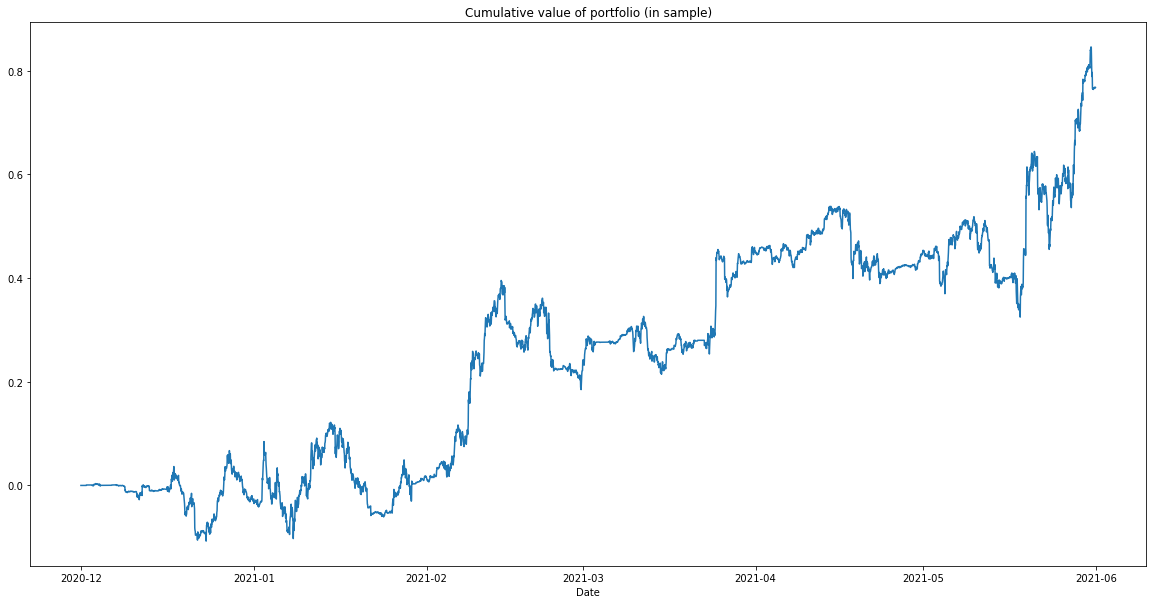

In [22]:
merge_ret = pd.concat(pf_retall, axis = 0)
merge_cumret = merge_ret.cumsum()/ttl_np
plt.plot(merge_cumret)
plt.xlabel('Date')
plt.title("Cumulative value of portfolio (in sample)")
plt.show()

In [23]:
SR = (merge_cumret[-1])*(8760/len(merge_cumret)) / (((merge_ret/ttl_np).std())*np.sqrt(8760))
print(SR)

2.3377250785210593


In [24]:
cost_sum = (fill_costs+fin_costs).sum().sum()*50000
cost_sum

-58543.32137373983

## buy and hold bitcoin

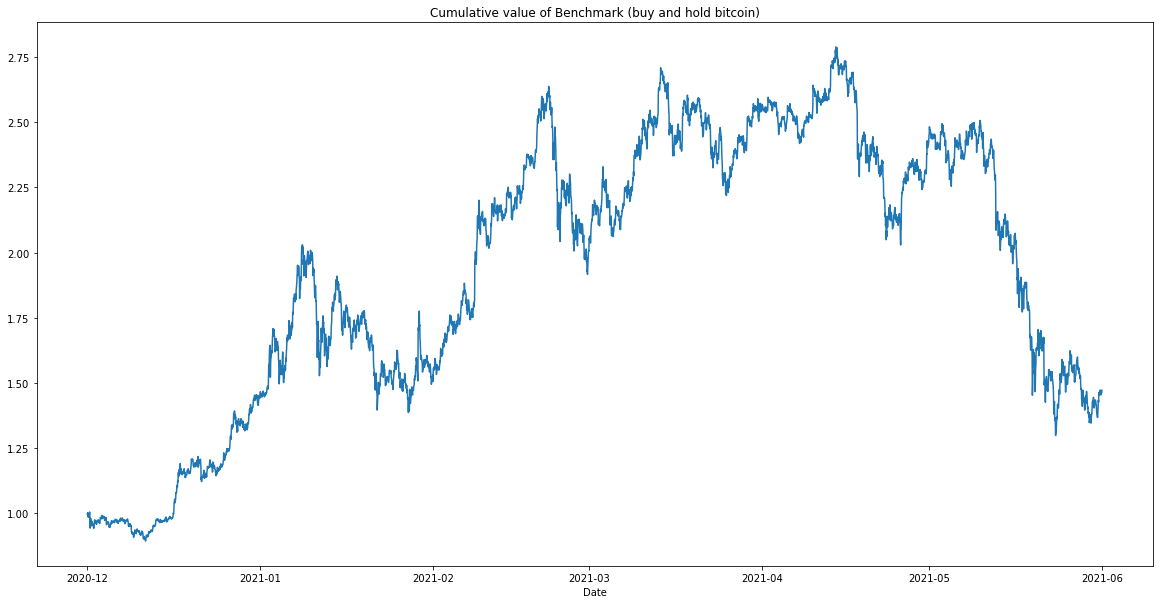

In [29]:
dr_btc = dr.loc[test_periods[0][0]:test_periods[0][1],'BTCUSDT']
dr_btc
dr_btc.iloc[0] = np.log(1/(1+3e-3))
dr_btc.iloc[-1] = dr_btc.iloc[-1] + np.log(1-2e-3)
cum_btc = ((ttl_np+ttl_np*dr_btc)/ttl_np).cumprod()
cum_btc
plt.plot(cum_btc)
plt.xlabel('Date')
plt.title("Cumulative value of Benchmark (buy and hold bitcoin)")
plt.show()